In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import pathlib

from random import randint

In [2]:
protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]


In [3]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


## Use the following equation for finding valid joint-pairs

![](./pose-estimation-paf-equation.png)

In the above equation:

L is the PAF;

d is the vector joining two joints;

p is the interpolated point between two joints;

It is implemented using the dot product between the PAF and the vector $d_{ij}$

In [4]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs


In [5]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [6]:
# image_path = "/Users/yohei/Documents/tlab/soccer/hoge.jpg"
image_path = "/Users/yohei/Documents/tlab/soccer/funa.jpg"
image1 = cv2.imread(image_path)
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

#### Load the network and pass the image through the network

In [7]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Time Taken = 3.7954471111297607


#### Slice a probability map ( for e.g Nose ) from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

(-0.5, 776.5, 799.5, -0.5)

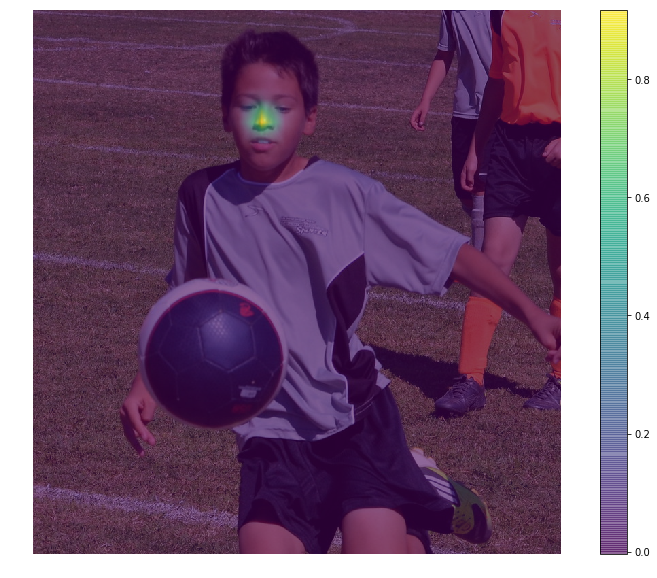

In [8]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [9]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)


Keypoints - Nose : [(336, 164, 0.9142974)]
Keypoints - Neck : [(354, 269, 0.8218831), (750, 0, 0.395612), (648, 0, 0.20004743)]
Keypoints - R-Sho : [(249, 269, 0.7384594), (699, 0, 0.64226925), (613, 0, 0.3651616)]
Keypoints - R-Elb : [(216, 443, 0.5099267), (681, 96, 0.6343756), (596, 61, 0.7605075)]
Keypoints - R-Wr : [(164, 531, 0.61499184), (647, 200, 0.82851183), (578, 130, 0.8580346)]
Keypoints - L-Sho : [(457, 269, 0.65415096), (769, 0, 0.120215036), (683, 0, 0.16421159)]
Keypoints - L-Elb : [(596, 355, 0.5362742)]
Keypoints - L-Wr : [(734, 460, 0.4802701)]
Keypoints - R-Hip : [(354, 634, 0.27226126), (631, 147, 0.4812393)]
Keypoints - R-Knee : [(353, 792, 0.1097747), (665, 373, 0.71352655), (631, 269, 0.5276035)]
Keypoints - R-Ank : [(646, 547, 0.6994064)]
Keypoints - L-Hip : [(476, 600, 0.2918405), (769, 201, 0.4206671), (683, 147, 0.28433433)]
Keypoints - L-Knee : [(664, 392, 0.11184215), (769, 375, 0.16007762), (682, 251, 0.10441522)]
Keypoints - L-Ank : [(751, 461, 0.199441

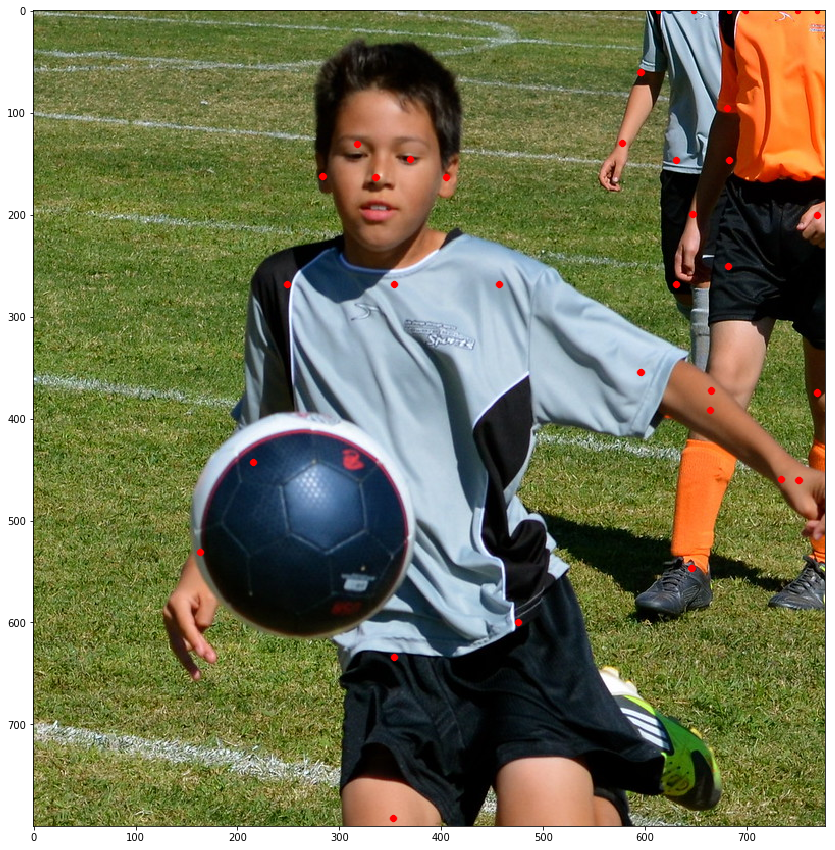

In [10]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [11]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[1.        , 4.        , 0.873561  ],
       [2.        , 5.        , 0.68244479],
       [3.        , 6.        , 0.25200172]]), array([[ 1.        , 13.        ,  0.93592965],
       [ 2.        , 14.        ,  0.53054102],
       [ 3.        , 15.        ,  0.10936482]]), array([[4.        , 7.        , 0.66607197],
       [5.        , 8.        , 0.81362338],
       [6.        , 9.        , 0.7152666 ]]), array([[ 7.        , 10.        ,  0.58156569],
       [ 8.        , 11.        ,  0.70307799],
       [ 9.        , 12.        ,  0.79699604]]), array([[13.        , 16.        ,  0.91441287]]), array([[16.        , 17.        ,  0.77519155]]), array([[ 1.        , 18.        ,  0.79192017],
       [ 3.        , 19.        ,  0.48704728]]), array([[18.        , 20.        ,  0.55523201],
       [19.        , 22.        ,  0.81989532]]), array([[21.       , 23.       ,  0.8827419]]), array([[ 1.        , 24.        ,  0.83505543],
       [ 2.        , 25.        ,  0.62828

In [12]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

In [13]:
keypoints_list

array([[3.36000000e+02, 1.64000000e+02, 9.14297402e-01],
       [3.54000000e+02, 2.69000000e+02, 8.21883082e-01],
       [7.50000000e+02, 0.00000000e+00, 3.95612001e-01],
       [6.48000000e+02, 0.00000000e+00, 2.00047433e-01],
       [2.49000000e+02, 2.69000000e+02, 7.38459408e-01],
       [6.99000000e+02, 0.00000000e+00, 6.42269254e-01],
       [6.13000000e+02, 0.00000000e+00, 3.65161598e-01],
       [2.16000000e+02, 4.43000000e+02, 5.09926677e-01],
       [6.81000000e+02, 9.60000000e+01, 6.34375572e-01],
       [5.96000000e+02, 6.10000000e+01, 7.60507524e-01],
       [1.64000000e+02, 5.31000000e+02, 6.14991844e-01],
       [6.47000000e+02, 2.00000000e+02, 8.28511834e-01],
       [5.78000000e+02, 1.30000000e+02, 8.58034611e-01],
       [4.57000000e+02, 2.69000000e+02, 6.54150963e-01],
       [7.69000000e+02, 0.00000000e+00, 1.20215036e-01],
       [6.83000000e+02, 0.00000000e+00, 1.64211586e-01],
       [5.96000000e+02, 3.55000000e+02, 5.36274195e-01],
       [7.34000000e+02, 4.60000

[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[14. -1.]
[15. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[ 2. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. 21.]
[-1. -1.]
[-1. -1.]
[20. -1.]
[-1. -1.]
[22. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. 26.]
[-1. -1.]
[24. -1.]
[25. -1.]
[-1. -1.]
[-1. 27.]
[-1. -1.]
[28. -1.]
[-1. -1.]
[-1. -1.]
[29. -1.]
[ 2. -1.]
[ 3. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]
[-1. -1.]


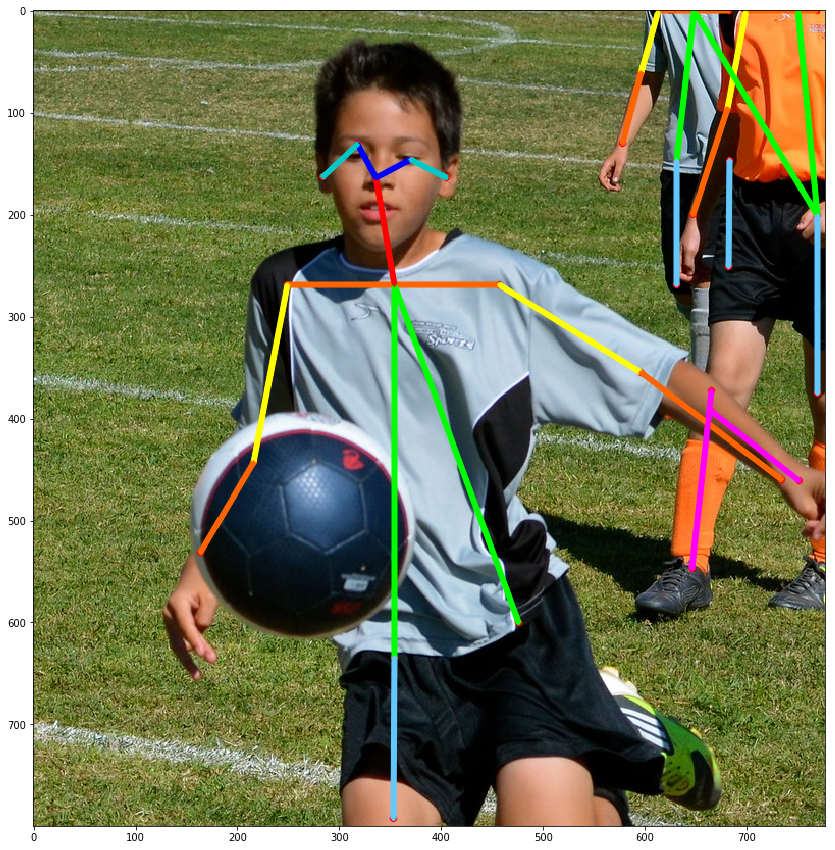

In [17]:
for i in range(17):  # keypoint
    for n in range(len(personwiseKeypoints)):  # 検出した人の数？
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:  # -1 は体全身が検出されなかったということ．
            print(index)
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [ ]:
a = index.astype(int)
keypoints_list[np.array([9, 33])]

In [ ]:
keypoints_list